In [1]:
import sys
import matplotlib.pyplot as plt
import numpy as np
from porespy import generators
from tomo_encoders.misc_utils.feature_maps_vis import view_midplanes
import cupy as cp
import time

from tomopy import project
sys.path.append('/data02/MyArchive/aisteer_3Dencoders/TomoEncoders/tomo_encoders/tasks/sparse_segmenter/')
from recon_subvol import fbp_filter, recon_patch

import os
import signal
import tomocg as pt

### Generate data

In [2]:
n = 512  # object size in x,y
nz = 505  # object size in z
ntheta = 1024  # number of angles (rotations)

theta = np.linspace(0,np.pi,ntheta,dtype='float32')
center = n/2.0
pnz = 4  # number of slices for simultaneous processing in tomography

In [3]:
vol = generators.blobs((nz,n,n), blobiness = 1.0).astype(np.float32)
# vol = np.zeros((nz,n,n))

object shape: (505, 512, 512)


array([<AxesSubplot:title={'center':'XY mid-plane'}>,
       <AxesSubplot:title={'center':'XZ mid-plane'}>,
       <AxesSubplot:title={'center':'YZ mid-plane'}>], dtype=object)

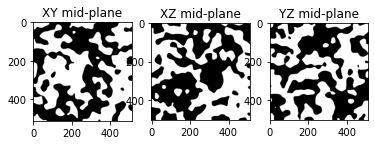

In [4]:
print("object shape: %s"%str(vol.shape))
view_midplanes(vol)

In [5]:
r = nz//2+25 # 25 overlap because some border pixels are being missed by solver
s1 = slice(None,r,None)
s2 = slice(-r,None,None)
u0 = vol[s1] + 1j*vol[s2]
# u0 = vol+1j*0

ngpus=1
# Class gpu solver
t0 = time.time()
with pt.SolverTomo(theta, ntheta, r, n, pnz, center, ngpus) as slv:
    # generate data
    data = slv.fwd_tomo_batch(u0)
#     projs = data.real
    
    projs = np.zeros((ntheta, nz, n), dtype = 'float32')
    projs[:,s1,:] = data.real
    projs[:,s2,:] = data.imag
    
print("time %.4f"%(time.time()- t0))
print("projections shape: %s"%str(projs.shape))


100%|██████████| 69/69 [00:01<00:00, 62.70it/s]


time 1.7738
projections shape: (1024, 505, 512)


### Reconstruct part

In [6]:
point = [100, 200, 150]
width = [128, 128, 128]

In [7]:
sub_vol = recon_patch(projs, theta, center, point, width, mem_limit_gpu = 5.0)

0.012014150619506836


array([<AxesSubplot:title={'center':'XY mid-plane'}>,
       <AxesSubplot:title={'center':'XZ mid-plane'}>,
       <AxesSubplot:title={'center':'YZ mid-plane'}>], dtype=object)

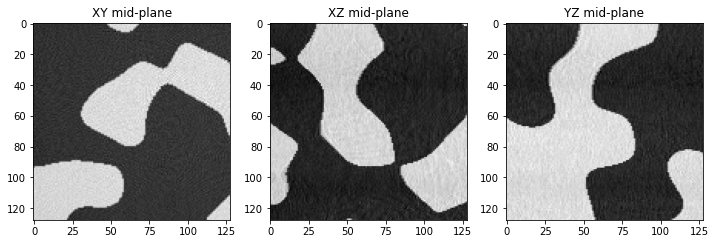

In [8]:
fig, ax = plt.subplots(1, 3, figsize = (12,6))
view_midplanes(sub_vol, ax = ax)

In [9]:
vol_new = vol.copy()
slices = tuple([slice(point[ii], point[ii] + width[ii]) for ii in range(3)])
sub_vol = (sub_vol - sub_vol.min()) / (sub_vol.max() - sub_vol.min())
vol_new[slices] = sub_vol

array([<AxesSubplot:title={'center':'XY mid-plane'}>,
       <AxesSubplot:title={'center':'XZ mid-plane'}>,
       <AxesSubplot:title={'center':'YZ mid-plane'}>], dtype=object)

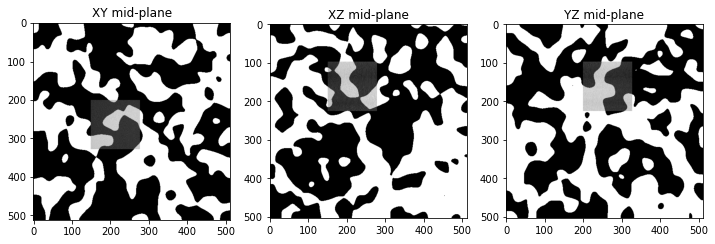

In [10]:
fig, ax = plt.subplots(1, 3, figsize = (12,6))
view_midplanes(vol_new, ax = ax, idxs = [point[j] + width[j]//2 for j in range(3)])

array([<AxesSubplot:title={'center':'XY mid-plane'}>,
       <AxesSubplot:title={'center':'XZ mid-plane'}>,
       <AxesSubplot:title={'center':'YZ mid-plane'}>], dtype=object)

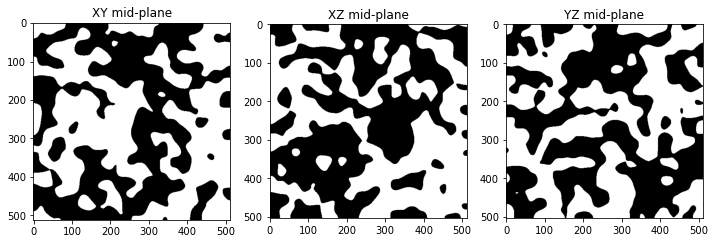

In [11]:
fig, ax = plt.subplots(1, 3, figsize = (12,6))
view_midplanes(vol, ax = ax)